# Урок: Сегментация

## Задание

* Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
* Опишите  результата. Что помогло повысить точность?
* *Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview4. 
* *Сделайте свою реализацию U-Net на TensorFlow


## Импорт библиотек

In [1]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, Concatenate, Input, Softmax

from google.colab import drive

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Датасет

### Ссылка: [Kaggle. Cityscapes Image Pairs](https://www.kaggle.com/dansbecker/cityscapes-image-pairs)

### Context

Cityscapes data (dataset home page) contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the Pix2Pix paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

### Content

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.


## Функции

In [2]:
drive.mount('/content/drive')

PATH_TRAIN = '/content/drive/MyDrive/Colab Notebooks/data/cityscapes_data/train/'
PATH_VAL = '/content/drive/MyDrive/Colab Notebooks/data/cityscapes_data/val/'

num_of_training_samples = len(os.listdir(PATH_TRAIN)) 
num_of_valid_samples = len(os.listdir(PATH_VAL))

Mounted at /content/drive


In [6]:
def load_image(name, path):
  img = Image.open(os.path.join(path, name))
  img = np.array(img)
  
  image = img[:,:256]
  mask = img[:,256:]
  
  return image, mask

def bin_image(mask):
  bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
  new_mask = np.digitize(mask, bins)
  return new_mask

def get_segmentation_arr(image, classes, width=WIDTH, height=HEIGHT):
  seg_labels = np.zeros((height, width, classes))
  img = image[:, : , 0]

  for c in range(classes):
    seg_labels[:, :, c] = (img == c ).astype(int)
  return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
  seg_img = np.zeros((seg.shape[0],seg.shape[1],3)).astype('float')
  colors = sns.color_palette("hls", n_classes)
  
  for c in range(n_classes):
    segc = (seg == c)
    seg_img[:,:,0] += (segc * (colors[c][0]))
    seg_img[:,:,1] += (segc * (colors[c][1]))
    seg_img[:,:,2] += (segc * (colors[c][2]))

  return (seg_img)

def data_generator(path, batch_size=BATCH_SIZE, classes=N_CLASSES):
  files = os.listdir(path)
  while True:
    for i in range(0, len(files), batch_size):
      batch_files = files[i : i+batch_size]
      imgs=[]
      segs=[]
      for file in batch_files:
        image, mask = load_image(file, path)
        mask_binned = bin_image(mask)
        labels = get_segmentation_arr(mask_binned, classes)

        imgs.append(image)
        segs.append(labels)

      yield np.array(imgs), np.array(segs)

## Подготовка данных

In [7]:
EPOCHS=10
BATCH_SIZE=10
HEIGHT=256
WIDTH=256
N_CLASSES=13

train_gen = data_generator(PATH_TRAIN, batch_size=BATCH_SIZE)
val_gen = data_generator(PATH_VAL, batch_size=BATCH_SIZE)

In [8]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

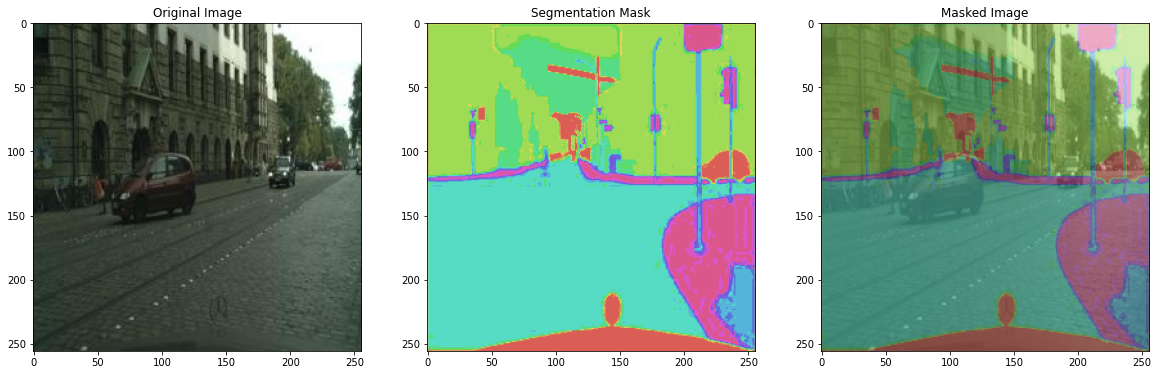

In [10]:
image = imgs[5]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')

axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')

axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

## Конфигурация модели

In [11]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((HEIGHT, WIDTH, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = Conv2D(13, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model

In [12]:
model = UNet()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Обучение

In [13]:
TRAIN_STEPS = num_of_training_samples // BATCH_SIZE + 1
VAL_STEPS = num_of_valid_samples // BATCH_SIZE + 1

history = model.fit_generator(
  train_gen,
  validation_data=val_gen,
  steps_per_epoch=TRAIN_STEPS,
  validation_steps=VAL_STEPS,
  epochs=EPOCHS
)

Epoch 1/10
283/283 [==============================] - 990s 3s/step - loss: 1.5113 - acc: 0.5766 - val_loss: 1.1850 - val_acc: 0.6729
Epoch 2/10
283/283 [==============================] - 57s 201ms/step - loss: 1.0895 - acc: 0.6944 - val_loss: 1.0664 - val_acc: 0.7053
Epoch 3/10
283/283 [==============================] - 58s 205ms/step - loss: 0.9624 - acc: 0.7308 - val_loss: 0.9451 - val_acc: 0.7405
Epoch 4/10
283/283 [==============================] - 58s 204ms/step - loss: 0.8722 - acc: 0.7565 - val_loss: 0.9125 - val_acc: 0.7469
Epoch 5/10
283/283 [==============================] - 58s 203ms/step - loss: 0.8216 - acc: 0.7693 - val_loss: 0.8815 - val_acc: 0.7605
Epoch 6/10
283/283 [==============================] - 58s 204ms/step - loss: 0.7859 - acc: 0.7788 - val_loss: 0.8634 - val_acc: 0.7626
Epoch 7/10
283/283 [==============================] - 57s 203ms/step - loss: 0.7608 - acc: 0.7852 - val_loss: 0.8232 - val_acc: 0.7737
Epoch 8/10
283/283 [==============================] - 57s

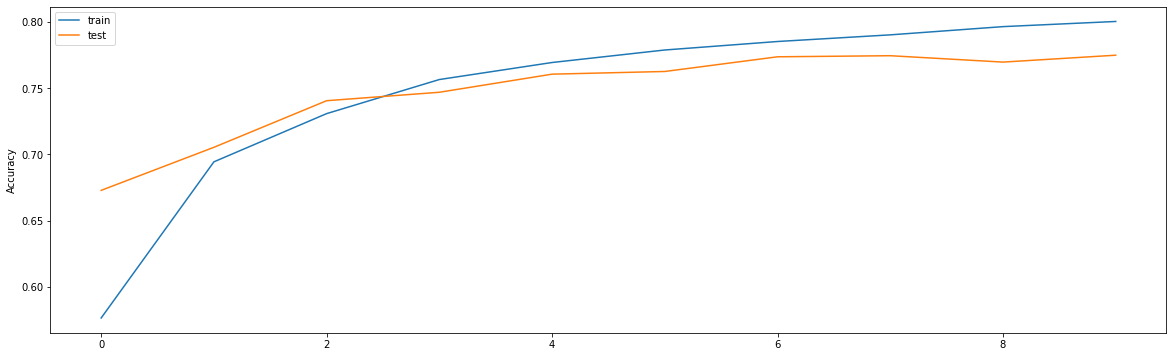

In [17]:
plt.figure(figsize=(20, 6))

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Визуализация предсказаний

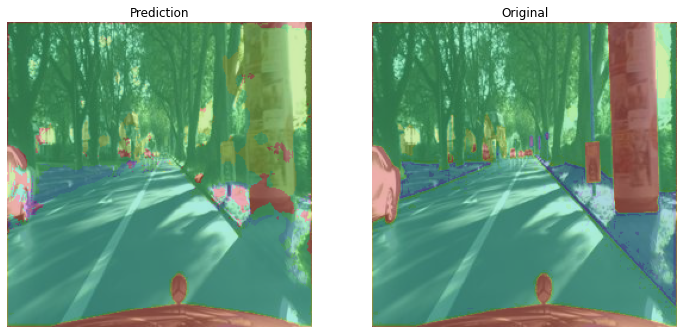

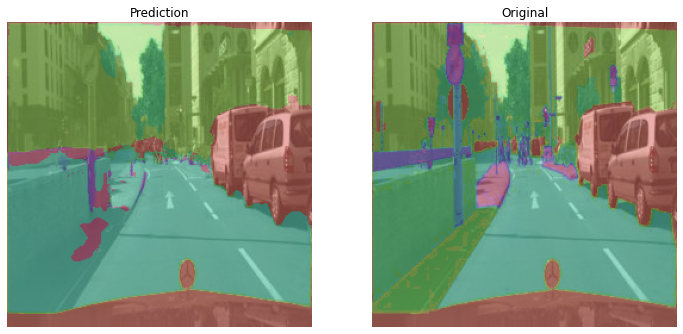

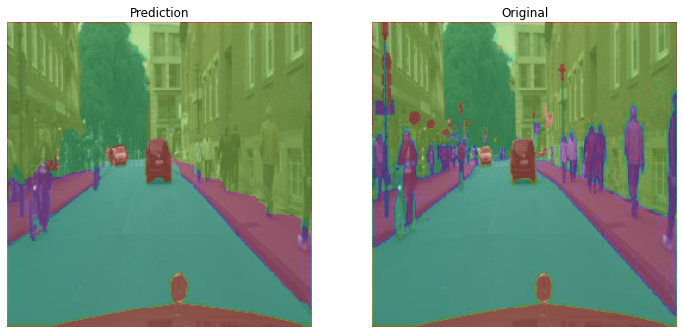

In [15]:
max_show = 3
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
  _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
  _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

  predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
  trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)
  
  plt.figure(figsize=(12,6))
  plt.subplot(121)
  plt.title("Prediction")
  plt.imshow(predimg)
  plt.axis("off")

  plt.subplot(122)
  plt.title("Original")
  plt.imshow(trueimg)
  plt.axis("off")
  plt.show()